#### Question 3 :

 On travaille dans le cadre du modèle de Black & Scholes. Dans toutes ces questions, on
 considère un call européen de maturité T et de strike K. On pourra prendre comme valeurs de référence $S_0 = 100$, $K = 100$, $T = 1$, $r = 0.05$, $σ = 0.20$, $d = 12$, $B = 140$, $L = 95$,
 $N = 10^4$ à $N = 10^5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
# Paramètres du modèle de Black-Scholes
S0 = 100  # Prix initial de l'actif sous-jacent
K = 100  # Strike de l'option
T = 1  # Maturité de l'option
d = 12
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.20  # Volatilité de l'actif sous-jacent
B = 140 # Niveau barrière
L = 95 
n_simulations = 100000

1. Tracer le prix de Monte-Carlo (avec intervalle de confiance) de l'option d'achat à barrière up-and-out de niveau B en fonction de $S_0$ (comparer avec le call standard). Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter. 

In [6]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def monte_carlo_up_and_out(S0, K, T, r, sigma, B, n_simulations, d):
    dt = T / d  
    payoff = np.zeros(n_simulations)  
    Z = np.random.standard_normal((n_simulations,d))
    S_path = np.zeros((n_simulations,d+1))
    S_path[:,0] = S0
    for t in range(1, d+1):
        S_path[:,t] = S_path[:,t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:,t-1])
    payoff = np.where(np.max(S_path, axis=1) < B, np.maximum(S_path[:,-1] - K, 0), 0)

    discounted_payoff = np.exp(-r * T) * payoff

    option_price = np.mean(discounted_payoff)

    sample_std = np.std(discounted_payoff, ddof=1)  
    standard_error = sample_std / np.sqrt(n_simulations) 
    z_critical = stats.norm.ppf(0.975)  
    confidence_interval = (option_price - z_critical * standard_error,
                           option_price + z_critical * standard_error)

    return option_price, confidence_interval

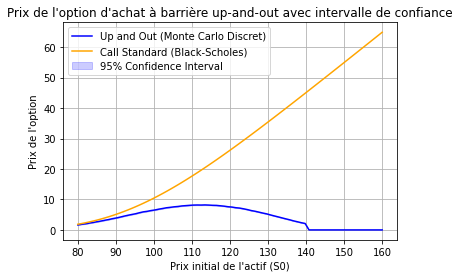

In [5]:
# Vecteur de prix initiaux S0
S0_values = np.linspace(80, 160, 80)

call_prices_mc = []
ci_lower = []
ci_upper = []

for S in S0_values:
    price, ci = monte_carlo_up_and_out(S, K, T, r, sigma, B, n_simulations, d)
    call_prices_mc.append(price)
    ci_lower.append(ci[0])
    ci_upper.append(ci[1])

# Prix des options calculés par Black-Scholes
call_prices_bs = [black_scholes_call(S, K, T, r, sigma) for S in S0_values]

plt.plot(S0_values, call_prices_mc, label='Up and Out (Monte Carlo Discret)', color='blue')
plt.plot(S0_values, call_prices_bs, label='Call Standard (Black-Scholes)', color='orange')

plt.fill_between(S0_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Prix initial de l'actif (S0)")
plt.ylabel("Prix de l'option")
plt.title("Prix de l'option d'achat à barrière up-and-out avec intervalle de confiance")
plt.legend()
plt.grid(True)
plt.show()

Plus le prix de l'actif sous-jacent tend vers 140, qui est la valeur de la barrière et plus le prix de l'option diminue. En effet, la probabilité de traverser la barrière augmente, ce qui voudrait dire que l'option ne va pas pouvoir être exercée. Ainsi, le prix est égal à 0 quand on atteint 140. La présence du saut doit être dûe à la méthode discrète.

Maintenant, on veut calculer avec la variante continue la valeur des options barrière. On dispose de la loi du $M_T^X = max_{0 \le u \le T}X_u$ sachant $X_T=\alpha T + B_T$.
A partir de $S_T = S_0 exp((r-\frac{1}{2}\sigma^2)T + \sigma B_T)$, on peut linéariser : $ln(S_T) = ln(S_0) + (r-\frac{1}{2}\sigma^2)T + \sigma B_T$, soit $\frac{ln(S_T)-ln(S_0)}{\sigma}=(\frac{r}{\sigma}-\frac{\sigma}{2})T + B_T$.

Donc on obtient les résultats suivants : $$X_T = \frac{ln(S_T)-ln(S_0)}{\sigma}, \alpha = \frac{r}{\sigma}-\frac{\sigma}{2}$$

Et ainsi :
$$max_{0 \le u \le T}S_u = exp(M_T^X \sigma + ln(S_0))$$

On va donc utiliser la formule de la loi conditionnelle de $M_T^X$ sachant $X_T$ pour réaliser cette variante continue.

In [6]:
def continuous_up_and_out_option(S0, K, T, r, sigma, B, n_simulations):
    Z = np.random.standard_normal(n_simulations)
    drift = (r/sigma - sigma/2)*T
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    XT = (np.log(ST)-np.log(S0))/sigma
    U = np.random.uniform(0,1, n_simulations)
    M = (XT+np.sqrt(XT**2-2*T*np.log(U)))/2
    S_max = np.exp(M*sigma+np.log(S0))

    payoff = np.where(S_max < B, np.maximum(ST - K, 0), 0)

    discounted_payoff = np.exp(-r * T) * payoff

    option_price = np.mean(discounted_payoff)
    sample_std = np.std(discounted_payoff, ddof=1)
    standard_error = sample_std / np.sqrt(n_simulations)
    z_critical = stats.norm.ppf(0.975)
    confidence_interval = (option_price - z_critical * standard_error, option_price + z_critical * standard_error)

    return option_price, confidence_interval

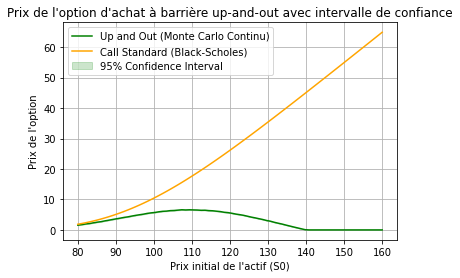

In [7]:
# Vecteur de prix initiaux S0
S0_values = np.linspace(80, 160, 80)

call_prices_mc_continu = []
ci_lower_continu = []
ci_upper_continu = []

for S in S0_values:
    price, ci = continuous_up_and_out_option(S, K, T, r, sigma, B, n_simulations)
    call_prices_mc_continu.append(price)
    ci_lower_continu.append(ci[0])
    ci_upper_continu.append(ci[1])

# Prix des options calculés par Black-Scholes
call_prices_bs = [black_scholes_call(S, K, T, r, sigma) for S in S0_values]

plt.plot(S0_values, call_prices_mc_continu, label='Up and Out (Monte Carlo Continu)', color='green')
plt.plot(S0_values, call_prices_bs, label='Call Standard (Black-Scholes)', color='orange')

plt.fill_between(S0_values, ci_lower_continu, ci_upper_continu, color='green', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Prix initial de l'actif (S0)")
plt.ylabel("Prix de l'option")
plt.title("Prix de l'option d'achat à barrière up-and-out avec intervalle de confiance")
plt.legend()
plt.grid(True)
plt.show()

A nouveau comme précédemment, plus le prix de l'actif sous-jacent tend vers 140, qui est la valeur de la barrière et plus le prix de l'option diminue. En effet, la probabilité de traverser la barrière augmente, ce qui voudrait dire que l'option ne va pas pouvoir être exercée. Ainsi, le prix est égal à 0 quand on atteint 140. Maintenant que nous avons implémenté une méthode continue, la transition sur la barrière se fait sans saut. 

 2. Tracer le prix Monte Carlo (avec intervalle de confiance) de l’option d’achat à barrière up-and-out (variante discrète) en fonction du nombre de dates d’observations. Ajouter le prix Monte Carlo (avec intervalle de confiance) de la variante continue. Commenter.

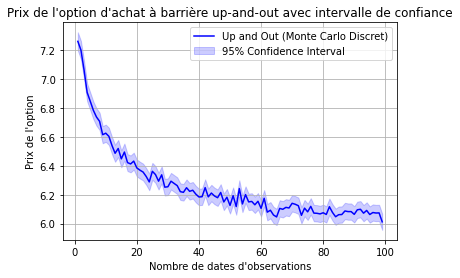

In [8]:
d_values = np.arange(1,100)
call_prices_mc_date = []
ci_lower_date = []
ci_upper_date = []
for t in d_values:
  price,ci = monte_carlo_up_and_out(S0, K, T, r, sigma, B, n_simulations, t)
  call_prices_mc_date.append(price)
  ci_lower_date.append(ci[0])
  ci_upper_date.append(ci[1])

plt.plot(d_values, call_prices_mc_date, label='Up and Out (Monte Carlo Discret)', color='blue')

plt.fill_between(d_values, ci_lower_date, ci_upper_date, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Nombre de dates d'observations")
plt.ylabel("Prix de l'option")
plt.title("Prix de l'option d'achat à barrière up-and-out avec intervalle de confiance")
plt.legend()
plt.grid(True)
plt.show()

Plus on augmente le nombre de dates d'observations, et plus le prix de l'option diminue. En effet, plus on surveille fréquemment le prix de l'option et plus on augmente la probabilité de toucher la barrière, ce qui va donc augmenter la probabilité d'annulation de l'option. 

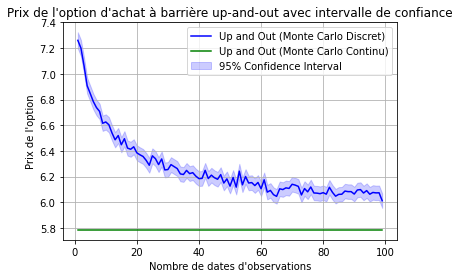

In [9]:
call_prices_continu_date = [continuous_up_and_out_option(S0, K, T, r, sigma, B, n_simulations)[0]]*len(d_values)
plt.plot(d_values, call_prices_mc_date, label='Up and Out (Monte Carlo Discret)', color='blue')
plt.plot(d_values, call_prices_continu_date, label='Up and Out (Monte Carlo Continu)', color='green')
plt.fill_between(d_values, ci_lower_date, ci_upper_date, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Nombre de dates d'observations")
plt.ylabel("Prix de l'option")
plt.title("Prix de l'option d'achat à barrière up-and-out avec intervalle de confiance")
plt.legend()
plt.grid(True)
plt.show()

Lorsqu'on observe en continu, le nombre de dates d'observations est considéré comme infini (c'est donc un cas limite). Ainsi, tout franchissement de la barrière va désactiver l'option ce qui fait que le prix de l'option continue est plus bas que la variante discrète. C'est en fait une valeur limite vers laquelle va tendre la variante discrète au fur et à mesure qu'on augmente le nombre de dates d'observations. Ainsi, les observations discrètes sont la réalité des marchés financiers là où les observations continues servent de bornes inférieures. 

3. Reprendre la question 1 pour un call down-and-in de niveau L.

In [3]:
# Pour un call down and in :
def down_and_in_option(S0, K, T, r, sigma, L, n_simulations, d):
    dt = T / d  
    payoff = np.zeros(n_simulations)  
    Z = np.random.standard_normal((n_simulations,d))
    S_path = np.zeros((n_simulations,d+1))
    S_path[:,0] = S0
    for t in range(1, d+1):
        S_path[:,t] = S_path[:,t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:,t-1])
    payoff = np.where(np.min(S_path, axis=1) <= L, np.maximum(S_path[:,-1] - K, 0), 0)

    discounted_payoff = np.exp(-r * T) * payoff

    option_price = np.mean(discounted_payoff)

    var = np.var(discounted_payoff, ddof=1)
    sample_std = np.std(discounted_payoff, ddof=1)  
    standard_error = sample_std / np.sqrt(n_simulations)
    z_critical = stats.norm.ppf(0.975) 
    confidence_interval = (option_price - z_critical * standard_error,
                           option_price + z_critical * standard_error)

    return option_price, confidence_interval, var 

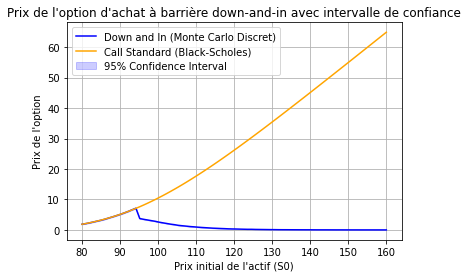

In [11]:
# Vecteur de prix initiaux S0
S0_values = np.linspace(80, 160, 80)

call_prices_mc_down_in = []
ci_lower_down = []
ci_upper_down = []
for S in S0_values:
    price, ci, std_discrete = down_and_in_option(S, K, T, r, sigma, L, n_simulations, d)
    call_prices_mc_down_in.append(price)
    ci_lower_down.append(ci[0])
    ci_upper_down.append(ci[1])

# Prix des options calculés par Black-Scholes
call_prices_bs = [black_scholes_call(S, K, T, r, sigma) for S in S0_values]

plt.plot(S0_values, call_prices_mc_down_in, label='Down and In (Monte Carlo Discret)', color='blue')
plt.plot(S0_values, call_prices_bs, label='Call Standard (Black-Scholes)', color='orange')

plt.fill_between(S0_values, ci_lower_down, ci_upper_down, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Prix initial de l'actif (S0)")
plt.ylabel("Prix de l'option")
plt.title("Prix de l'option d'achat à barrière down-and-in avec intervalle de confiance")
plt.legend()
plt.grid(True)
plt.show()

Lorsque le prix de l'actif sous-jacent est supérieur à 95, qui est la valeur de la barrière activante, le prix de l'option tend vers 0 au fur et à mesure qu'il s'éloigne de 95. En effet, la probabilité de traverser la barrière diminue, ce qui voudrait dire que l'option ne va pas pouvoir être exercée car elle ne sera pas activée. En se rapprochant de 95, on assiste à une augmentation du prix puisque la probabilité de franchir la barrière augmente. La présence du saut doit être dûe à la méthode discrète. Enfin, lorsqu'on atteint le niveau de la barrière, le prix du Call est maximal et l'option se comporte ensuite comme un Call classique ce qui explique la forme de la courbe similaire à celle du Call de Black Scholes. 

4. Implémenter un Monte Carlo conditionnel pour le pricing du call down-and-in (i.e. utiliser l’information disponible au franchissement de la barrière). Quel est la facteur de réduction de variance obtenu ? Comparer avec une réduction par variables antithétiques (comparer le coefficients de réduction obtenu et le théorique estimé par simulation). Commenter.

In [12]:
# Monte Carlo conditionnel sur le prix du down-and-in

def conditional_monte_carlo_down_and_in(S0, K, T, r, sigma, L, n_simulations, d):
    dt = T / d
    payoff_values = np.zeros(n_simulations)
    Z = np.random.standard_normal((n_simulations, d))

    # On simule jusqu'à ce que la barrière soit atteinte ou la maturité.
    for n in range(n_simulations):
        S_path = S0
        hit_times = None
        for t in range(1, d + 1):
            S_path = S_path * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[n,t-1])
            if S_path <= L:
                hit_times = t*dt
                break   
        if hit_times is not None:
            remaining_time = T - hit_times
            S_hit = S_path
            payoff = black_scholes_call(S_hit,K,remaining_time,r,sigma)
        else:
            payoff = 0.0
        payoff_values[n] = payoff 

    discounted_payoff = np.exp(-r * T) * payoff_values
    option_price = np.mean(discounted_payoff)
    var = np.var(discounted_payoff, ddof=1)
    sample_std = np.std(discounted_payoff, ddof=1)
    standard_error = sample_std / np.sqrt(n_simulations)
    z_critical = stats.norm.ppf(0.975)
    confidence_interval = (option_price - z_critical * standard_error, option_price + z_critical * standard_error)

    return option_price, confidence_interval, var

<ipython-input-4-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


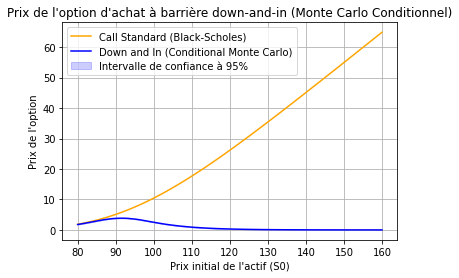

In [14]:
# S0_values = np.linspace(80, 160, 80)

# call_prices_mc_down_in_cond = []
# ci_lower_down_cond = []
# ci_upper_down_cond = []

# for S in S0_values:
#     price, ci, std_conditionnel = conditional_monte_carlo_down_and_in(S, K, T, r, sigma, L, n_simulations, d)
#     call_prices_mc_down_in_cond.append(price)
#     ci_lower_down_cond.append(ci[0])
#     ci_upper_down_cond.append(ci[1])

# call_prices_bs = [black_scholes_call(S, K, T, r, sigma) for S in S0_values]

# plt.plot(S0_values, call_prices_bs, label='Call Standard (Black-Scholes)', color='orange')
# plt.plot(S0_values, call_prices_mc_down_in_cond, label='Down and In (Conditional Monte Carlo)', color='blue')
# plt.fill_between(S0_values, ci_lower_down_cond, ci_upper_down_cond, color='blue', alpha=0.2, label='Intervalle de confiance à 95%')
# plt.xlabel("Prix initial de l'actif (S0)")
# plt.ylabel("Prix de l'option")
# plt.title("Prix de l'option d'achat à barrière down-and-in (Monte Carlo Conditionnel)")
# plt.legend()
# plt.grid(True)
# plt.show()

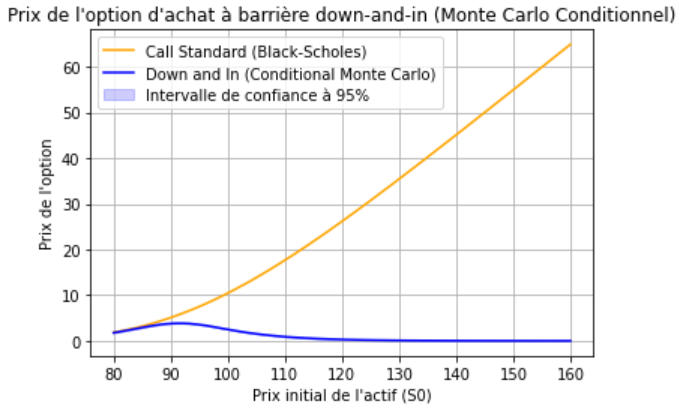

Le code prenant du temps à s'éxécuter, nous avons affiché la courbe résultante sous la forme d'une capture d'écran. On constate que le prix du Call a été lissé par rapport à la variante discrète. En effet, on exploite la connaissance de manière continue du prix de l'option une fois la barrière franchie, ce qui nous a permis d'utiliser la formule de Black Scholes directement. 

<ipython-input-4-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


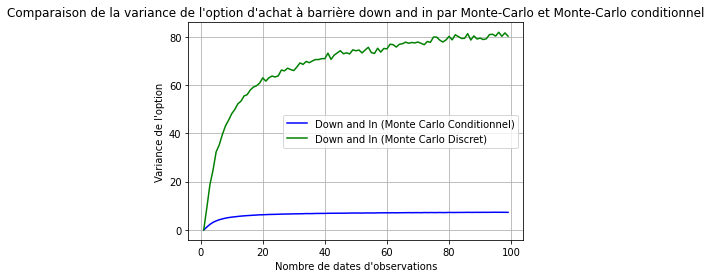

In [15]:
# d_values = np.arange(1,100)
# call_variance_mc_conditionnel_date = []
# call_variance_mc_date = []
# for t in d_values:
#   price,ci, std = conditional_monte_carlo_down_and_in(S0, K, T, r, sigma, L, n_simulations, t)
#   price_2, ci_2, std_2 = down_and_in_option(S0, K, T, r, sigma, L, n_simulations, t)
#   call_variance_mc_conditionnel_date.append(std)
#   call_variance_mc_date.append(std_2)

# plt.plot(d_values, call_variance_mc_conditionnel_date, label='Down and In (Monte Carlo Conditionnel)', color='blue')
# plt.plot(d_values, call_variance_mc_date, label='Down and In (Monte Carlo Discret)', color='green')
# plt.xlabel("Nombre de dates d'observations")
# plt.ylabel("Variance de l'option")
# plt.title("Comparaison de la variance de l'option d'achat à barrière down and in par Monte-Carlo et Monte-Carlo conditionnel")
# plt.legend()
# plt.grid(True)
# plt.show()

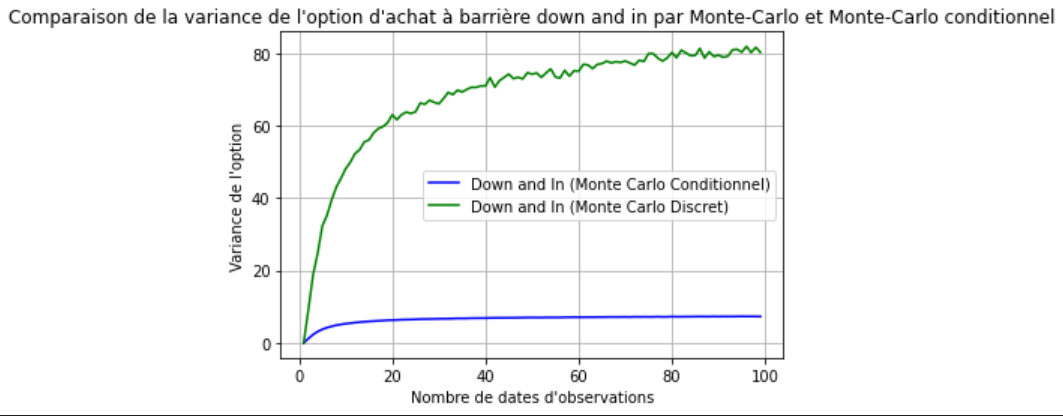

In [16]:
print("Le facteur de réduction de la np.mean(call_variance_mc_date)variance avec Monte Carlo Conditionnel est :", down_and_in_option(S0, K, T, r, sigma, L, n_simulations, d)[2]/conditional_monte_carlo_down_and_in(S0, K, T, r, sigma, L, n_simulations, d)[2])

<ipython-input-4-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Le facteur de réduction de la np.mean(call_variance_mc_date)variance avec Monte Carlo Conditionnel est : 9.252660936880865


Nous remarquons sur le graphique, ainsi que lors du calcul que la variance est grandement réduite par l'utilisation de Monte Carlo conditionnel à la place de Monte Carlo discret. Pour un $d=12$, on arrive à un facteur de réduction de lors de 9 de la variance. Ainsi, l'utilisation de la connaissance continue du prix de l'option une fois la barrière franchie a participé à réduire l'incertitude sur le prix de l'option. 

In [4]:
def monte_carlo_down_and_in_antithetic(S0, K, T, r, sigma, L, n_simulations, d):
    dt = T / d
    payoff_values = np.zeros(n_simulations)
    Z = np.random.standard_normal((n_simulations // 2, d))
    Z_antithetic = -Z
    Z_combined = np.concatenate((Z,Z_antithetic))
    # On simule jusqu'à ce que la barrière soit atteinte ou la maturité.
    for n in range(n_simulations):
        S_path = S0
        hit_times = None
        for t in range(1, d + 1):
            S_path = S_path * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z_combined[n,t-1])
            if S_path <= L:
                hit_times = t*dt
                break   
        if hit_times is not None:
            remaining_time = T - hit_times
            S_hit = S_path
            payoff = black_scholes_call(S_hit,K,remaining_time,r,sigma)
        else:
            payoff = 0.0
        payoff_values[n] = payoff 

    discounted_payoff = np.exp(-r * T) * payoff_values
    option_price = np.mean(discounted_payoff)
    var = np.var(discounted_payoff, ddof=1)
    sample_std = np.std(discounted_payoff, ddof=1)
    standard_error = sample_std / np.sqrt(n_simulations)
    z_critical = stats.norm.ppf(0.975)
    confidence_interval = (option_price - z_critical * standard_error, option_price + z_critical * standard_error)

    return option_price, confidence_interval, var

<ipython-input-6-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


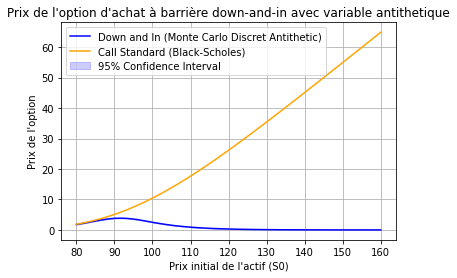

In [ ]:
# # Vecteur de prix initiaux S0
# S0_values = np.linspace(80, 160, 80)

# # Initialize lists to store results
# call_prices_mc_antithetic = []
# ci_lower_antithetic = []
# ci_upper_antithetic = []
# std_downn_in_antithetic = []

# # Compute prices and confidence intervals for each S0
# for S in S0_values:
#     price, ci, std_antithetic = monte_carlo_down_and_in_antithetic(S, K, T, r, sigma, L, n_simulations, d)
#     call_prices_mc_antithetic.append(price)
#     ci_lower_antithetic.append(ci[0])
#     ci_upper_antithetic.append(ci[1])
#     std_downn_in_antithetic.append(std_antithetic)

# # Prix des options calculés par Black-Scholes
# call_prices_bs = [black_scholes_call(S, K, T, r, sigma) for S in S0_values]

# # Plotting results
# plt.plot(S0_values, call_prices_mc_antithetic, label='Down and In (Monte Carlo Antithetic)', color='blue')
# plt.plot(S0_values, call_prices_bs, label='Call Standard (Black-Scholes)', color='orange')

# # Add confidence intervals as a shaded region
# plt.fill_between(S0_values, ci_lower_antithetic, ci_upper_antithetic, color='blue', alpha=0.2,
#                  label='95% Confidence Interval')

# plt.xlabel("Prix initial de l'actif (S0)")
# plt.ylabel("Prix de l'option")
# plt.title("Prix de l'option d'achat à barrière down-and-in avec variable antithetique")
# plt.legend()
# plt.grid(True)
# plt.show()

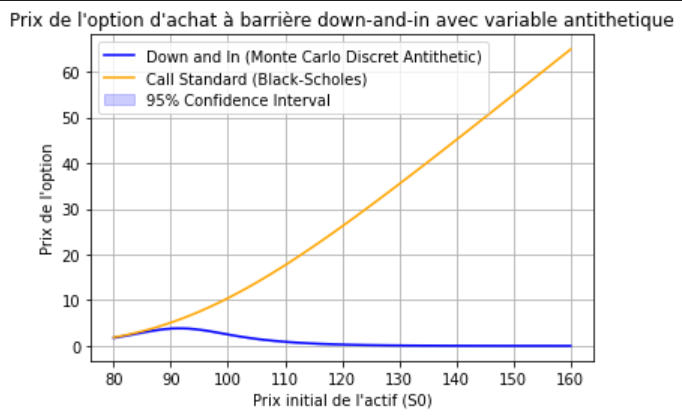

On constate que le prix du Call a été à nouveau lissé par rapport à la variante discrète. En effet, on exploite la connaissance de manière continue du prix de l'option une fois la barrière franchie à laquelle on rajoute la méthode antithétique de réduction de la variance.

<ipython-input-6-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


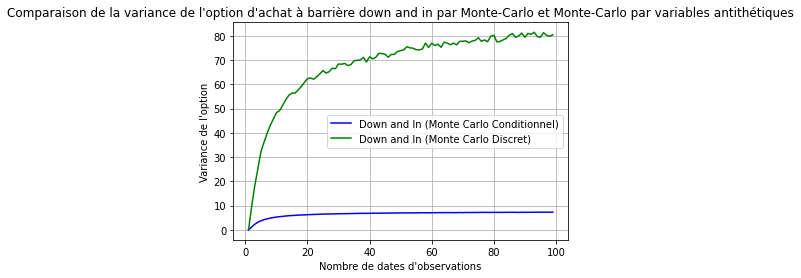

In [8]:
# d_values = np.arange(1,100)
# call_variance_mc_conditionnel_date = []
# call_variance_mc_date = []
# for t in d_values:
#   price,ci, std = monte_carlo_down_and_in_antithetic(S0, K, T, r, sigma, L, n_simulations, t)
#   price_2, ci_2, std_2 = down_and_in_option(S0, K, T, r, sigma, L, n_simulations, t)
#   call_variance_mc_conditionnel_date.append(std)
#   call_variance_mc_date.append(std_2)

# plt.plot(d_values, call_variance_mc_conditionnel_date, label='Down and In (Monte Carlo Antithétique)', color='blue')
# plt.plot(d_values, call_variance_mc_date, label='Down and In (Monte Carlo Discret)', color='green')
# plt.xlabel("Nombre de dates d'observations")
# plt.ylabel("Variance de l'option")
# plt.title("Comparaison de la variance de l'option d'achat à barrière down and in par Monte-Carlo et Monte-Carlo par variables antithétiques")
# plt.legend()
# plt.grid(True)
# plt.show()

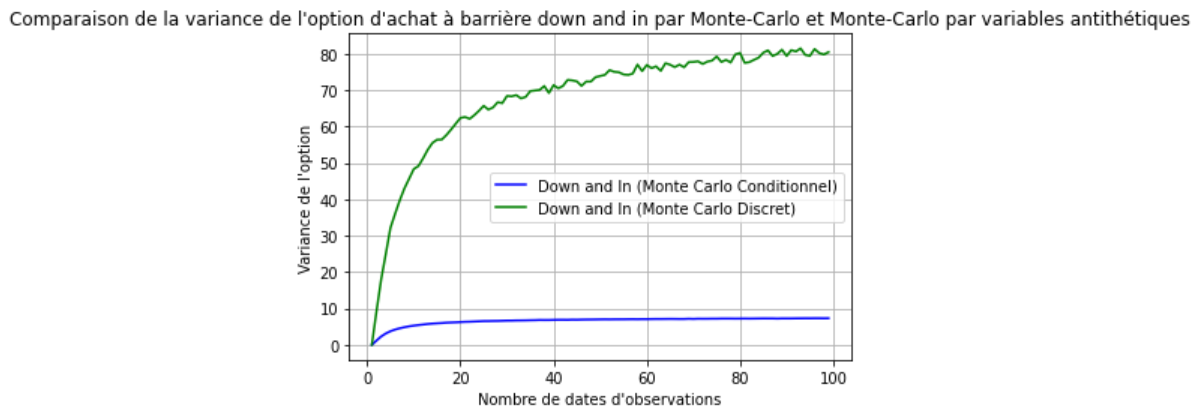

In [9]:
print("Le facteur de réduction de la variance avec Monte Carlo Antithétique Conditionnel est :", down_and_in_option(S0, K, T, r, sigma, L, n_simulations, d)[2]/monte_carlo_down_and_in_antithetic(S0, K, T, r, sigma, L, n_simulations, d)[2])

<ipython-input-6-171bf02bf3d3>:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Le facteur de réduction de la variance avec Monte Carlo Antithétique est : 9.160304952634792


On réduit la variance d'un facteur similaire à celui de la méthode Monte Carlo conditionnel. La méthode de réduction de la variance antithétique en plus de la méthode conditionnel ne réduit pas plus la variance. 